# Coursework 3: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW3.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *CAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*
3. You training losses as *train_losses_CAE.npy*, *train_losses_D.npy*, *train_losses_G.npy*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 28th February, 2019**

## Introduction

For this coursework you are asked to implement two commonly used generative models:
1. A **Convolutional Autoencoder (CAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

The dataset you will be using is the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)

1. For the CAE, the success of your models will be tested as follows:
    - **By the autoencoders' reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training loss curve, reconstruction error on the test set and some reconstructed images in the respective cells.
    - **By the representation learning capabilities of your model**. In particular, autoencoders are known to be able to learn quite informative features in their latent space (embeddings) that can later be used for downstream tasks. In this coursework you are asked to use the representations that your pre-trained encoder yields in order to do image classification. You can use your favourite classification module on top of the features in order to solve the problem *(Hint: a simple Support Vector Machine - SVM - is acceptable. Alternatively, you can devise more complex models such as a Multilayer Fully Connected Network)*.
 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize. ')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [9]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [10]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [11]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')
##############################################
print('sample_inputs',sample_inputs.size())
# basically image size 32*32 there are 128 image in total. 3 represent RGB
print('fixed_input',fixed_input.size())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
sample_inputs torch.Size([128, 3, 32, 32])
fixed_input torch.Size([32, 3, 32, 32])


## Part 1 - Convolutional Autoencoder

### Part 1.1 (30 points)
**Your Task**: 

a. Implement the CAE architecture. Fill in the missing parts in the cells below in order to complete the CAE class. You will need to define:

- The hyperparameters
- The constructor
- `encode`
- `decode`

b. Plot your training loss curve (x-axis: epochs, y-axis: loss)

c. Calculate the reconstruction error on your test set

d. Visualize a subset of the images of the test set and their reconstructions

For b., c. and d. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Some reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer or fully connected layer.
- use the appropriate activation functions. 
- Encoder module: hierarchially downsample your images with pooling layers, or strided convolutions.
- Decoder module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices. **You will need to choose sufficiently large size for your latent vectors (hidden_size variable), in order to allow enough capacity for your network to represent the data.**

The number of epochs that will be needed in order to train the network will vary depending on your choices. In most of the cases, it will be a long procedure (a few hours), so you can leave your notebook running until the training converges.  You don't need to train the network to an extreme if you don't have the time. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture.

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs and the learning rate.
num_epochs = 20
learning_rate  = 1e-3
###

# Define here other hyperparameters that you used.
latent_dim = 32

batch_size = 128



### Define model

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose a value for the latent space dimension and use it in your model
hidden_size = None
###

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################    
        # encoder layers
        self.conv1 = nn.Conv2d(3, 16, 4, stride=2, padding=1) #  convolution layer 1
        self.batchNormal1 = nn.BatchNorm2d(16) # Batch normal 1
        self.maxp1 = nn.MaxPool2d(2, stride=2) # max-pooling 1
        self.conv2 = nn.Conv2d(16, 8, 6, stride=2, padding=1)  #  convolution layer 2
        self.batchNormal2 = nn.BatchNorm2d(8) # Batch normal 2
        self.maxp2 = nn.MaxPool2d(2, stride=1) # max-pooling 2
        self.fc = nn.Linear(32, 32) #  fully connected layer 
        
        # decoder layers
        self.deconv1 = nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.batchNormalA = nn.BatchNorm2d(16) # Batch normal 1
        self.deconv2 = nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.batchNormalB = nn.BatchNorm2d(8) # Batch normal 1
        self.deconv3 = nn.ConvTranspose2d(8, 3, 6, stride=2, padding=1)
        self.batchNormalC = nn.BatchNorm2d(3) # Batch normal 1
        self.tanh = nn.Tanh()
        
        # relu
        self.relu = nn.ReLU(True)
        # leakyReLu
        self.leakyReLU = nn.LeakyReLU(0.2, inplace=True)

    def encode(self, x):
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
 
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
      
        # b, 3, 32, 32]

        x = self.leakyReLU(self.conv1(x)) # b, 16, 12, 12
        x = self.maxp1(x) # b, 16, 6, 6
        
        x = self.conv2(x) # b, 8, 3, 3
        x = self.batchNormal2(x)
        x = self.leakyReLU(x)
        
        x = self.maxp2(x) # b, 8, 2, 2
        x = x.view(x.size(0), -1) # b, 8*2*2
        x = self.fc(x) # b, h_dim

        return x

    
    def decode(self, z):
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
 
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        z = z.view(z.size(0), 8, 2, 2) # b, 8, 2, 2
        z = self.relu(self.deconv1(z)) # b, 16, 5, 5
        z = self.batchNormalA(z)
        z = self.relu(self.deconv2(z)) # b, 8, 15, 15
        z = self.batchNormalB(z)
        z = self.tanh(self.deconv3(z)) # b, 3, 32, 32
        z = self.batchNormalC(z)
        return z

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean')  # can we use any other loss here? You are free to choose.
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [61]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 11801
CAE(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNormal1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  (batchNormal2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxp2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (deconv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (batchNormalA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
  (batchNormalB): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2

### Choose and initialize optimizer

In [0]:
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.01, 0.001), eps=1e-06, weight_decay=0, amsgrad=False)

### Train

In [65]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
print(np.array(train_losses).shape)
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model.pth') #loss 0.06 ?

epoch [1/20], loss:0.0748
epoch [2/20], loss:0.0727
epoch [3/20], loss:0.0719
epoch [4/20], loss:0.0710
epoch [5/20], loss:0.0705
epoch [6/20], loss:0.0698
epoch [7/20], loss:0.0692
epoch [8/20], loss:0.0687
epoch [9/20], loss:0.0684
epoch [10/20], loss:0.0678
epoch [11/20], loss:0.0674
epoch [12/20], loss:0.0672
epoch [13/20], loss:0.0667
epoch [14/20], loss:0.0666
epoch [15/20], loss:0.0662
epoch [16/20], loss:0.0659
epoch [17/20], loss:0.0658
epoch [18/20], loss:0.0655
epoch [19/20], loss:0.0653
epoch [20/20], loss:0.0652
(20,)


### Train loss curve

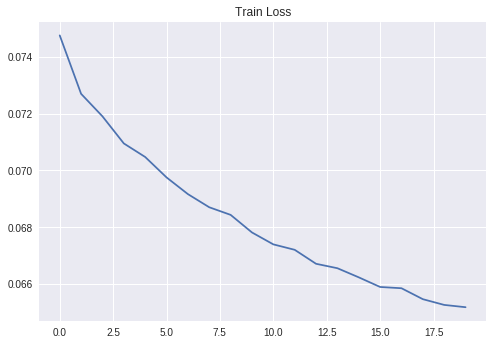

In [66]:
import matplotlib.pyplot as plt
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [67]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0005


### Test set images and reconstructions

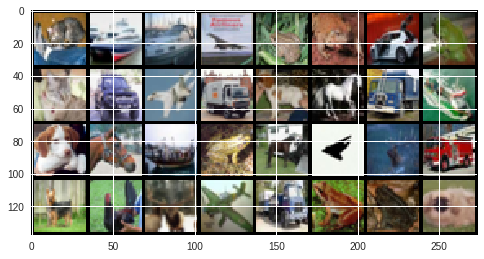

In [68]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

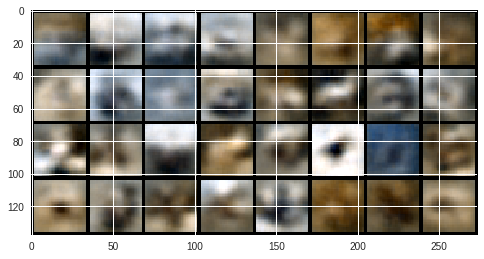

In [69]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

### Part 1. 2 (20 points)
**Your Task**: 

In this part of the exercise you will use your pretrained encoder as a feature extractor in order to solve a downstream task:
* For every sample of your training set you will need to extract its latent representation by passing it through the encoder.
* Create a classifier of your choice and train it with the extracted features in order to predict the class that each image belongs to. You can access the sample's classes as follows:

`it = iter(loader_test)
samples, classes = next(it)`
* Use the encoder to encode all your test images into latent representations and then use your trained classifier to predict their classes
* Print the accuracy of your model.

The classifier can be trained with representations that do not yield very accurate reconstructions, so you can stop your training even if the reconstructed images are blurry. Also, note that you do not have to acheive high classification accuracy to get full marks for this question. Instead, focus on describing how you experimented in order to build your best classifier.

In [92]:
# *CODE FOR PART 1.2 IN THIS CELL*

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
# cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
#                              transform=transform)
# cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
#                            transform=transform)
# cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
#                             transform=transform)

# loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
# loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
# loader_test = DataLoader(cifar10_test, batch_size=batch_size)

from sklearn.neural_network import MLPClassifier
    
 
itrain = iter(loader_train) 
samples_Train, classes_Train = next(itrain)

samples_Train = samples_Train.to(device)

feature = model.encode(samples_Train)


### Part 1. 2 (20 points)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(5, 2), 
                    random_state=1)
print(feature.cpu().detach().numpy().shape)
print(classes_Train.cpu().detach().numpy().shape)
clf.fit(feature.cpu().detach().numpy() , classes_Train.cpu().detach().numpy() )     


itest = iter(loader_test) 
samples_Test, classes_Test = next(itest)
samples_Test = samples_Test.to(device)
feature2 = model.encode(samples_Test)

print('the accuracy is ')
clf.score(feature2.cpu().detach().numpy(), classes_Test.cpu().detach().numpy())






(128, 32)
(128,)
the accuracy is 


0.109375

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plos with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epoch, the learning rate
#   and the size of the Generator's input noise vetor.

# Define here other hyperparameters that you used.

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of z latent vector (i.e. size of generator input) aka nz
latent_vector_size = 32

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
learning_rate  = 2e-3


# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [0]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # decoder layers
        self.deconv1 = nn.ConvTranspose2d( 32, ngf * 8, 4, stride = 1, padding = 0, bias=False)
        self.batchNormalA = nn.BatchNorm2d(ngf * 8) # Batch normal A
        
        self.deconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, stride = 2, padding = 1, bias=False)
        self.batchNormalB = nn.BatchNorm2d(ngf * 4) # Batch normal B
        
        self.deconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, stride = 2, padding =1, bias=False)
        self.batchNormalC = nn.BatchNorm2d(ngf * 2) # Batch normal C
        
        self.deconv4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, stride = 2, padding =1, bias=False)
        self.batchNormalD = nn.BatchNorm2d(ngf) # Batch normal D

        self.deconv5 = nn.ConvTranspose2d( ngf, nc, 3, stride = 1, padding =1, bias=False) 
         
        self.sigmoid = nn.Sigmoid()
        
        # relu
        self.relu = nn.ReLU(True)
        
        #tan
        self.tanh = nn.Tanh()
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
       


        z = self.relu(self.batchNormalA(self.deconv1(z))) 
#         print('2',z.size()) # 2 torch.Size([128, 512, 4, 4])
        
        z = self.relu(self.batchNormalB(self.deconv2(z))) 
#         print('3',z.size()) # 3 torch.Size([128, 256, 8, 8])
        
        z = self.sigmoid(self.batchNormalC(self.deconv3(z))) 
#         print('4',z.size()) # 4 torch.Size([128, 128, 16, 16])

        z = self.sigmoid(self.batchNormalD(self.deconv4(z)))
#         print('5',z.size()) # 5 torch.Size([128, 64, 32, 32])
        
        z = self.deconv5(z)
#         print('6',z.size()) # 6 torch.Size([128, 3, 33, 33])
        
        return self.tanh(z)
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def forward(self, z):
        return self.decode(z)

      


      

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # encoder layers
        # input is (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)
        
        # state size. (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(ndf * 2)
        # state size. (ndf*2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(ndf * 4)
 
        # state size. (ndf*4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False)
        self.batchNorm4 = nn.BatchNorm2d(ndf * 8)

        # state size. (ndf*8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf * 8, 1, 2, stride=1, padding=0, bias=False)
           
        #leaky Sigmoid
        self.sigmoid = nn.Sigmoid()
        #leaky ReLU
        self.leakyReLU = nn.LeakyReLU(0.2, inplace=True)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # torch.Size([128, 3, 32, 32])
#         print('1',x.size())
        
        x = self.leakyReLU(self.conv1(x)) 
#         print('2',x.size()) # 2 torch.Size([128, 64, 16, 16])
        
        x = self.leakyReLU(self.batchNorm2(self.conv2(x))) 
#         print('3',x.size()) # 3 torch.Size([128, 128, 8, 8])
        
        x = self.leakyReLU(self.batchNorm3(self.conv3(x))) # b, 1*1*1
#         print('4',x.size()) # 4 torch.Size([128, 256, 4, 4])
        
        x = self.leakyReLU(self.batchNorm4(self.conv4(x))) # b, 1*1*1
#         print('5',x.size()) # 5 torch.Size([128, 512, 2, 2])

        x = self.conv5(x)
#         print('6',x.size())
        return self.sigmoid(x)

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)
      
      

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [238]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3018304
Generator(
  (deconv1): ConvTranspose2d(32, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchNormalA): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNormalB): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNormalC): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchNormalD): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace)
  (tan

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
learning_rate  = 1e-3
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [242]:
export_folder = './CW/DCGAN'
train_losses_G = []
train_losses_D = []


for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        
#         print(output.size())
#         print(label.size())
        
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
print(np.array(train_losses_D).flatten().shape)
np.save('./CW/DCGAN/train_losses_D.npy',np.array(train_losses_D))
np.save('./CW/DCGAN/train_losses_G.npy',np.array(train_losses_G))
torch.save(model_G.state_dict(), './CW/DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW/DCGAN/DCGAN_model_D.pth')

[0/20][0/383] Loss_D: 1.4777 Loss_G: 12.5818 D(x): 0.5937 D(G(z)): 0.5914 / 0.0000
[0/20][1/383] Loss_D: 6.8748 Loss_G: 12.8180 D(x): 0.5036 D(G(z)): 0.9972 / 0.0000
[0/20][2/383] Loss_D: 1.1903 Loss_G: 10.4863 D(x): 0.4221 D(G(z)): 0.0000 / 0.0000
[0/20][3/383] Loss_D: 0.0468 Loss_G: 6.0544 D(x): 0.9713 D(G(z)): 0.0148 / 0.0031
[0/20][4/383] Loss_D: 11.2667 Loss_G: 7.4013 D(x): 0.9965 D(G(z)): 1.0000 / 0.0006
[0/20][5/383] Loss_D: 0.0216 Loss_G: 7.8124 D(x): 0.9862 D(G(z)): 0.0073 / 0.0004
[0/20][6/383] Loss_D: 0.0870 Loss_G: 7.1976 D(x): 0.9339 D(G(z)): 0.0022 / 0.0007
[0/20][7/383] Loss_D: 0.0583 Loss_G: 5.6657 D(x): 0.9577 D(G(z)): 0.0130 / 0.0035
[0/20][8/383] Loss_D: 0.1950 Loss_G: 8.7450 D(x): 0.9707 D(G(z)): 0.1515 / 0.0002
[0/20][9/383] Loss_D: 0.1308 Loss_G: 9.1940 D(x): 0.8996 D(G(z)): 0.0003 / 0.0001
[0/20][10/383] Loss_D: 0.0522 Loss_G: 8.8040 D(x): 0.9550 D(G(z)): 0.0002 / 0.0002
[0/20][11/383] Loss_D: 0.0261 Loss_G: 6.7938 D(x): 0.9776 D(G(z)): 0.0027 / 0.0025
[0/20][12/

In [0]:
# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*

"""
Discriminator

Structure of Discriminator has 5 convolution layers. A leaky Relu will be applied to the first convolution.   
A leaky Relu and batch normolisation will be applied in the 2th,3th,4th convolution layer         
apply sigmoid function after 5th convolution layer      

 
Generator:

Structure of Discriminator has 5 deconvolution layers.
apply relu function to the 1th and 2th layer.
apply sigmoid to the 3th and 4th layer.
apply tanh to the last layer.

"""

### Generator samples

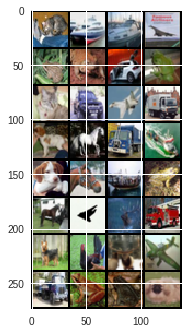

In [254]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

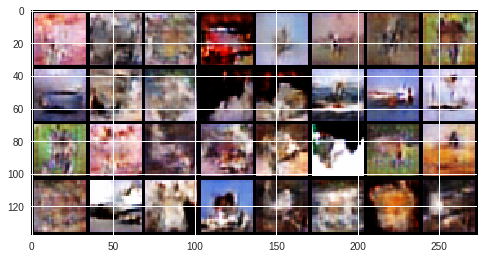

In [256]:
# load the model
model_G.load_state_dict(torch.load('./CW/DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

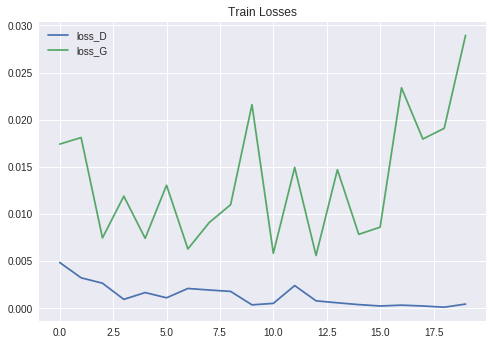

In [245]:
import matplotlib.pyplot as plt
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')
plt.plot(list(range(0,train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0,train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

In [249]:
# ANSWER FOR PART 2.2 IN THIS CELL* explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).
"""produced curves are theoretically sensible. overall the trainning loss of Discriminator is higher than the Generator on average 
The goal of Generator is let Discriminator think it has generated real data. The loss of the discriminator is decreasing so that it can tell the real from fake
however the loss of Generator is going up and down which mean it is getting stronger and stronger (generating mroe real data) until a point they reach a point like a 
nash equilibrium, generator is makeing 'real' data and Discriminator is not able to tell that the image is real. In other words Discriminator is not able to tell the 'real'
from fake."""

"produced curves are theoretically sensible. overall the trainning loss of Discriminator is higher than the Generator on average \nThe goal of Generator is let Discriminator think it has generated real data. The loss of the discriminator is decreasing so that it can tell the real from fake\nhowever the loss of Generator is going up and down which mean it is getting stronger and stronger (generating mroe real data) until a point they reach a point like a \nnash equilibrium, generator is makeing 'real' data and Discriminator is not able to tell that the image is real. In other words Discriminator is not able to tell the 'real'\nfrom fake."

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [120]:
# ANSWER FOR PART 2.3 IN THIS CELL*  whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.
"""
some pictures collapse there is one piecture with red backgroup and another picture with red object they collapse into a whole noisy red picture. we can try Historical averaging to handle 
this issue. another obvious strategy to avoid this type of failure is to allow the discriminator to look at multiple data examples in combination, and perform what we call 
minibatch discrimination
"""



In [0]:
from google.colab import files
files.download('../content/CW/CAE/CAE_model.pth')
files.download('../content/CW/DCGAN/DCGAN_model_D.pth')
files.download('../content/CW/DCGAN/DCGAN_model_G.pth')
files.download('../content/CW/CAE/train_losses.npy')
files.download('../content/CW/DCGAN/train_losses_D.npy')
files.download('../content/CW/DCGAN/train_losses_G.npy')
